In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [26]:
CONFIG = {
    'sample_maze': {
        'generate': {
            'maze_shape': (4,4),
            'num_mazes': 1,
        },
        'draw': {
            'wall_thickness': 2,
            'figsize': (4,4),
        }
    },
    'dataset': {
        'generate': {
            'maze_shape' : (5,5),
            'num_mazes': 5_000,
        },
        'get_imgs': {
            'img_config': {
                'cell_size': 10
            }
        }
    }
    
}

In [30]:
class Maze:
    def __init__(self, shape):
        self.shape = shape
        
        self.NORTH, self.EAST, self.WEST, self.SOUTH = [0b1000, 0b0100, 0b0010, 0b0001]
        self.ALL = 0b1111
        
        self.maze = np.zeros(self.shape, dtype = np.int8) + self.ALL 

    def set_maze(self, new_maze):
        self.shape = new_maze.shape
        self.maze = new_maze

    def is_out_of_bounds(self, point):
        return point[0] < 0 or point[0] >= self.shape[0] or point[1] < 0 or point[1] >= self.shape[1]

    
    def draw(self, wall_thickness=2, figsize=(6, 6)):
        H, W = self.shape
        fig, ax = plt.subplots(figsize=figsize)
    
        # Disable axes spines and ticks
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(False)
    
        # Draw walls for each cell
        for y in range(H):
            for x in range(W):
                walls = self.maze[y, x]
                x0, y0 = x, y  # Top-left origin: no y-flip
                # Draw walls if present
                if walls & self.NORTH:  # North
                    ax.plot([x0, x0 + 1], [y0, y0], 'k-', linewidth=wall_thickness, solid_capstyle='butt')
                if walls & self.EAST:  # East
                    ax.plot([x0 + 1, x0 + 1], [y0, y0 + 1], 'k-', linewidth=wall_thickness, solid_capstyle='butt')
                if walls & self.WEST:  # West
                    ax.plot([x0, x0], [y0, y0 + 1], 'k-', linewidth=wall_thickness, solid_capstyle='butt')
                if walls & self.SOUTH:  # South
                    ax.plot([x0, x0 + 1], [y0 + 1, y0 + 1], 'k-', linewidth=wall_thickness, solid_capstyle='butt')
    
        # Draw outer border explicitly with same thickness
        ax.plot([0, W], [0, 0], 'k-', linewidth=wall_thickness + 2, solid_capstyle='butt')      # Top
        ax.plot([0, W], [H, H], 'k-', linewidth=wall_thickness + 2, solid_capstyle='butt')      # Bottom
        ax.plot([0, 0], [0, H], 'k-', linewidth=wall_thickness + 2, solid_capstyle='butt')      # Left
        ax.plot([W, W], [0, H], 'k-', linewidth=wall_thickness + 2, solid_capstyle='butt')      # Right
    
        # Set limits and aspect
        ax.set_aspect('equal')
        ax.set_xlim(0, W)
        ax.set_ylim(0, H)
        ax.invert_yaxis()  
        
        plt.show()
        
    
    def get_maze_img(self, cell_size=30):
        maze = self.maze
        H, W = maze.shape
        img_h = H * cell_size + (H+1) * cell_size # H empty and H+1 walls 
        img_w = W * cell_size + (W+1) * cell_size
        img = np.zeros((img_h, img_w, 3), dtype=np.uint8) + 255
    
        for y in range(H):
            for x in range(W):
                cx, cy = (2*x+1)*cell_size, (2*y+1)*cell_size
                walls = maze[y, x]
    
                if walls & self.NORTH:
                    tl = [cx - cell_size, cy - cell_size]
                    tr = [cx + 2 * cell_size, cy - cell_size]
                    br = [cx + 2 * cell_size, cy]
                    bl = [cx - cell_size, cy]
                    poly = np.array([tl, tr, br, bl], dtype=np.int32).reshape((-1, 1, 2))
                    cv2.fillPoly(img, [poly], 0)
                
                if walls & self.EAST:
                    tl = [cx + cell_size, cy - cell_size]
                    tr = [cx + 2 * cell_size, cy - cell_size]
                    br = [cx + 2 * cell_size, cy + 2 * cell_size]
                    bl = [cx + cell_size, cy + 2 * cell_size]
                    poly = np.array([tl, tr, br, bl], dtype=np.int32).reshape((-1, 1, 2))
                    cv2.fillPoly(img, [poly], 0)
    
                if walls & self.WEST:
                    tl = [cx - cell_size, cy - cell_size]
                    tr = [cx, cy - cell_size]
                    br = [cx, cy + 2 * cell_size]
                    bl = [cx - cell_size, cy + 2 * cell_size]
                    poly = np.array([tl, tr, br, bl], dtype=np.int32).reshape((-1, 1, 2))
                    cv2.fillPoly(img, [poly], 0)
                    
                if walls & self.SOUTH:
                    tl = [cx - cell_size, cy + cell_size]
                    tr = [cx + 2 * cell_size, cy + cell_size]
                    br = [cx + 2 * cell_size, cy + 2 * cell_size]
                    bl = [cx - cell_size, cy + 2 * cell_size]
                    poly = np.array([tl, tr, br, bl], dtype=np.int32).reshape((-1, 1, 2))
                    cv2.fillPoly(img, [poly], 0)
                      
        return img


class MazeGenerator:
    def __init__(self):
        self.dirns = np.array([[-1,0], [0,1], [0,-1], [1,0]]) # NEWS
        self.NORTH, self.EAST, self.WEST, self.SOUTH = [0b1000, 0b0100, 0b0010, 0b0001]
        self.ALL = 0b1111
        self.dirn_masks = [self.NORTH, self.EAST, self.WEST, self.SOUTH]
    
    def generate(self, maze, point):
        rand_dirns = np.random.permutation(4)
        for k in rand_dirns:
            next_point = point+self.dirns[k]
            if maze.is_out_of_bounds(next_point): continue
            if maze.maze[next_point[0], next_point[1]] == self.ALL:
                maze.maze[point[0], point[1]] &= ~self.dirn_masks[k]
                maze.maze[next_point[0], next_point[1]] &= ~self.dirn_masks[3-k]
                self.generate(maze, point + self.dirns[k])

        return maze
    
    def generate_mazes(self, maze_shape, num_mazes=1):
        if num_mazes == 1:
            rand_loc = [np.random.randint(maze_shape[0]), np.random.randint(maze_shape[1])]
            return self.generate(Maze(maze_shape), np.array(rand_loc))
        
        mazes = []
        for i in range(num_mazes):
            rand_loc = [np.random.randint(maze_shape[0]), np.random.randint(maze_shape[1])]
            mazes.append(self.generate(Maze(maze_shape), np.array(rand_loc)))
            
            print(f"\r{i+1}/{num_mazes} mazes generated",end = '')
        print()
        return np.asarray(mazes)

    
    def filter_duplicates(self, maze_dataset):

        if maze_dataset.ndim == 3:
            N, H, W = maze_dataset.shape
            C = 1
        else:
            N, H, W, C = maze_dataset.shape
        maze_dataset_reshaped = maze_dataset.reshape(N, -1)
        
        contiguous_dataset = np.ascontiguousarray(maze_dataset_reshaped).view(
            np.dtype((np.void, maze_dataset_reshaped.dtype.itemsize * H * W * C))
        )
        
        _, unique_idx = np.unique(contiguous_dataset, return_index=True)
        unique_idx.sort()  # sort indices back to original order
        unique_mazes = maze_dataset[unique_idx]
        return unique_mazes

    
    def get_maze_images(self, mazes, img_config={}):
        images = []
        num_mazes = len(mazes)
        for i,maze in enumerate(mazes):
            images.append(maze.get_maze_img(**img_config))
            print(f"\r{i+1}/{num_mazes} images created.",end = '')
        print()
        return np.asarray(images)


In [31]:
maze_gen = MazeGenerator()
sample_maze = maze_gen.generate_mazes(**CONFIG['sample_maze']['generate'])

(270, 270, 3)


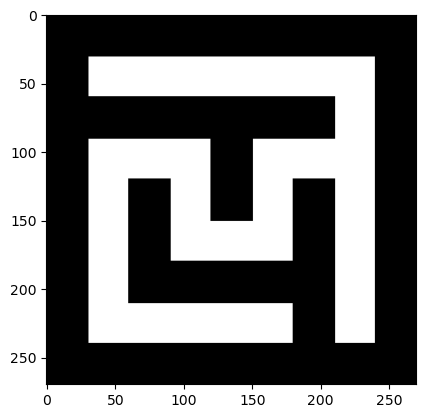

(4, 4)


In [32]:
# sample_maze.draw(**CONFIG['sample_maze']['draw'])
plt.imshow(sample_maze.get_maze_img())
print(sample_maze.get_maze_img().shape)
plt.show()
print(sample_maze.maze.shape)

In [33]:
mazes = maze_gen.generate_mazes(**CONFIG['dataset']['generate'])
dataset = maze_gen.get_maze_images(mazes, **CONFIG['dataset']['get_imgs'])

mazes_arr = []
for maze in mazes:
    mazes_arr.append(maze.maze)
mazes_arr = np.asarray(mazes_arr)

mazes_unq = maze_gen.filter_duplicates(mazes_arr)
dataset_unq = maze_gen.filter_duplicates(dataset)

print(mazes_unq[0].shape)

print(f"Image dimensions: {dataset.shape[1:]}")
print(f"Before filter: {dataset.shape[0]} images")
print(f"After filter: {dataset_unq.shape[0]} images")

np.save("Data/mazes5by5.npy", mazes_unq, allow_pickle = False)
np.save("Data/maze_imgs5by5.npy", dataset_unq, allow_pickle = False)

5000/5000 mazes generated
5000/5000 images created.
(5, 5)
Image dimensions: (110, 110, 3)
Before filter: 5000 images
After filter: 4973 images


[[11  9  8  8 13]
 [10 13  6  3 12]
 [ 6 11  1 13  6]
 [ 3  9  9  9  4]
 [11  9  9  9  5]]


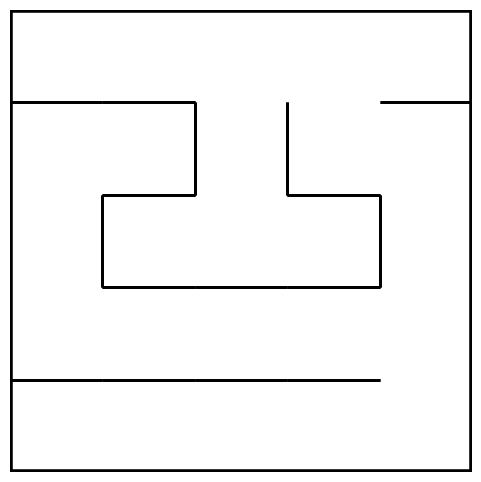

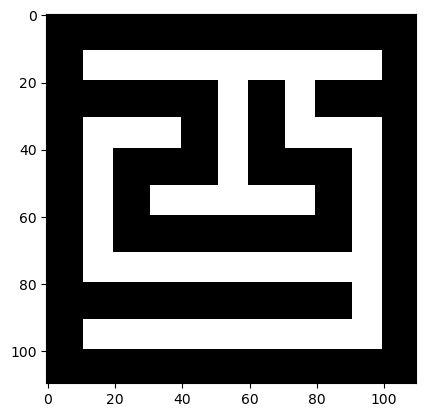

In [11]:
idx = 86
print(mazes_unq[idx])
test_maze = Maze((6,6))
test_maze.set_maze(mazes_unq[idx])
test_maze.draw()
plt.imshow(dataset_unq[idx])